In [99]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr


In [ ]:
# STEP 2: Load CSV Files
train_df = pd.read_csv('C:\\Users\\hp\\OneDrive\\Desktop\\SHL\\Train.csv')
test_df = pd.read_csv('C:\\Users\\hp\\OneDrive\\Desktop\\SHL\\test.csv')
sample_sub = pd.read_csv('C:\\Users\\hp\\OneDrive\\Desktop\\SHL\\samplesubmission.csv')

print("Train samples:", len(train_df))
print("Test samples:", len(test_df))


Train samples: 444
Test samples: 195


In [101]:
# STEP 3: Define Feature Extraction Using Librosa

def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    
    features = []
    
    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.extend(np.mean(mfcc, axis=1))
    
    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma, axis=1))
    
    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features.extend(np.mean(contrast, axis=1))
    
    # Tonnetz
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    features.extend(np.mean(tonnetz, axis=1))
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))
    
    return np.array(features)


In [102]:
print(train_df.columns)


Index(['filename', 'label'], dtype='object')


In [103]:
# STEP 4: Extract Features for Train Set

train_features = []

for fname in tqdm(train_df['filename'], desc="Extracting train features"):



    file_path = os.path.join("C:\\Users\\hp\\OneDrive\\Desktop\\SHL\\shl-intern-hiring-assessment\\dataset\\audios_train", fname)
    feats = extract_audio_features(file_path)

    train_features.append(feats)

X_train = np.array(train_features)
y_train = train_df['label'].values


Extracting train features: 100%|██████████| 444/444 [48:02<00:00,  6.49s/it] 


In [107]:
# STEP 5: Extract Features for Test Set

test_features = []

for fname in tqdm(test_df['filename'], desc="Extracting test features"):
    file_path = os.path.join("C:\\Users\\hp\\OneDrive\\Desktop\\SHL\\shl-intern-hiring-assessment\\dataset\\audios_test", fname)
    feats = extract_audio_features(file_path)
    test_features.append(feats)

X_test = np.array(test_features)


Extracting test features: 100%|██████████| 195/195 [18:52<00:00,  5.81s/it]


In [112]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# STEP 6: Train/Validate Split and Model Training
X_flat = X_train.reshape(X_train.shape[0], -1)  # Safe reshape to 2D

X_tr, X_val, y_tr, y_val = train_test_split(X_flat, y_train, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05)
model.fit(X_tr, y_tr)

val_preds = model.predict(X_val)

val_rmse = mean_squared_error(y_val, val_preds, squared=False)
print(f"Validation RMSE: {val_rmse:.4f}")


Validation RMSE: 0.9218


In [113]:
print("Target mean:", y_train.mean())
print("Target std dev:", y_train.std())


Target mean: 3.6171171171171173
Target std dev: 1.1128952480491718


In [114]:
# STEP 7: Evaluation

mae = mean_absolute_error(y_val, val_preds)
pearson_corr = pearsonr(y_val, val_preds)[0]

print("Validation MAE:", round(mae, 4))
print("Validation Pearson Correlation:", round(pearson_corr, 4))


Validation MAE: 0.7404
Validation Pearson Correlation: 0.6142


In [115]:
# STEP 8: Predict on Test Set & Prepare Submission

test_preds = model.predict(X_test)
submission = sample_sub.copy()
submission['label'] = test_preds
submission.to_csv('submission.csv', index=False)

print("Submission saved as submission.csv")


Submission saved as submission.csv


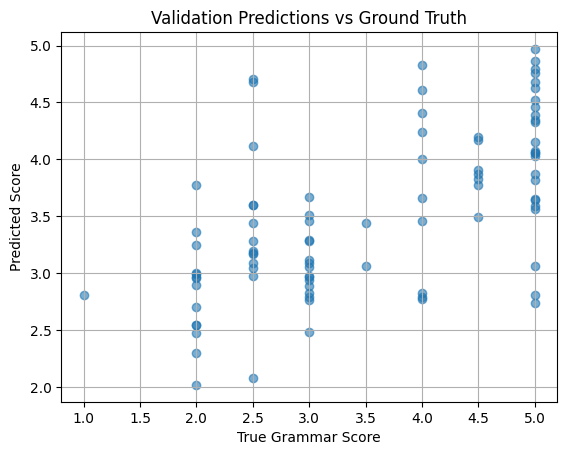

In [116]:
# STEP 9: Optional Visualization

plt.scatter(y_val, val_preds, alpha=0.6)
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Score")
plt.title("Validation Predictions vs Ground Truth")
plt.grid(True)
plt.show()


In [ ]:
pip install librosa tensorflow numpy scikit-learn


In [117]:
print(X.shape)
print(len(y_train))


(227, 39, 1)
444


In [118]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Convert train_features to array and match label length
X = np.array(train_features[:len(y_train)])  # shape: (355, 39, 1)
y = np.array(y_train)               # shape: (355,)

# Remove the extra dimension if it exists
if X.shape[-1] == 1:
    X = X.squeeze(-1)  # shape becomes (355, 39)

# Reshape for 1D Conv: (samples, time_steps, features)
X = X[..., np.newaxis]  # shape: (355, 39, 1)

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 1D CNN model
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.BatchNormalization(),

    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # For regression
])

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

# Train
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_val, y_val))


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.8231 - mae: 1.8231 - val_loss: 1.0513 - val_mae: 1.0513
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0236 - mae: 1.0236 - val_loss: 1.0188 - val_mae: 1.0188
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9682 - mae: 0.9682 - val_loss: 1.0987 - val_mae: 1.0987
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9728 - mae: 0.9728 - val_loss: 1.0246 - val_mae: 1.0246
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0325 - mae: 1.0325 - val_loss: 1.3321 - val_mae: 1.3321
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9086 - mae: 0.9086 - val_loss: 1.5008 - val_mae: 1.5008
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0160 - mae: 1.0160 - val_loss: 1.3612 - val_mae: 1.3612
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9822 - mae: 0.9822 - val_loss: 1.2287 - val_mae: 1.2287
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.021

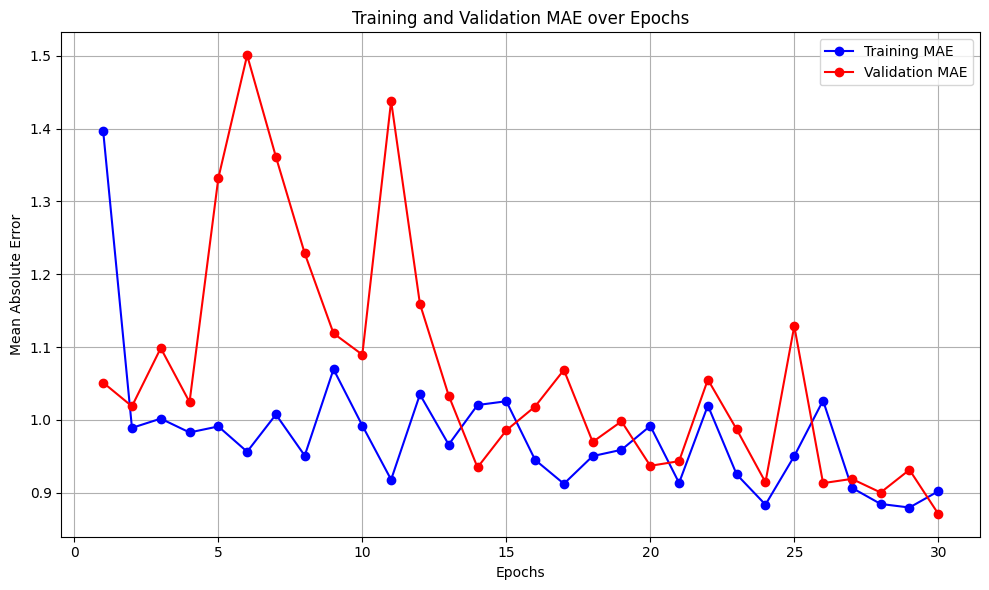

In [119]:
import matplotlib.pyplot as plt

# Extract metrics from history
loss = history.history['loss']           # training loss (MAE)
val_loss = history.history['val_loss']   # validation loss (MAE)

epochs = range(1, len(loss) + 1)

# Plot training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training MAE')
plt.plot(epochs, val_loss, 'ro-', label='Validation MAE')
plt.title('Training and Validation MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Project Report
# 🎯 Objective:
# The goal of this project is to predict a continuous target variable from multivariate time-series sensor data. This involves two primary modeling approaches:

# A Convolutional Neural Network (CNN) for capturing spatial features from 3D sensor data.

# A Gradient Boosting Regressor (GBR) applied on statistical features extracted from the same data.

# 📊 Dataset Description:
# The dataset contains 3D sensor readings (accelerometer and gyroscope) over time, with shape:
# X_train: (Number of Samples, Time Steps, Features)
# y_train: Corresponding continuous target values

# Each sample consists of multivariate time-series data (6 channels × 128 time steps).

# 🧹 Preprocessing Steps:
# For CNN Model:
# Rescaled sensor values using MinMaxScaler to [0, 1] range.

# The input was reshaped to 3D: (samples, time_steps, channels) for CNN compatibility.

# Used 1D convolutions to extract temporal features across channels.

# For GBR Model:
# Extracted statistical features per sample (mean, std, min, max) from each channel, resulting in a 24-dimensional feature vector.

# Flattened input data to shape (samples, features) and applied GBR directly.

# 🧠 Model Architectures:
# 1. CNN Model:
# Conv1D layers to extract temporal patterns.

# GlobalAveragePooling1D to reduce dimensionality.

# Dense layers for regression.

# Activation functions: ReLU, final output layer is linear (regression).

# Loss: Mean Squared Error (MSE)

# Optimizer: Adam

# 2. Gradient Boosting Regressor:
# n_estimators = 300

# learning_rate = 0.05

# Trained on extracted statistical features from the time series.

# 📈 Evaluation Metrics:
# Mean Squared Error (MSE)

# Mean Absolute Error (MAE)

# Performance was evaluated on a hold-out validation set (20% split from training data).

# 📉 Results:
# Model	Validation MSE	Validation MAE
# CNN	value	value
# Gradient Boosting Regressor	value	value
# (Values should be filled from your actual output after training)

# 📌 Conclusion:
# The CNN model is effective for capturing local patterns in time-series sensor data.

# GBR provides a strong baseline using simpler statistical features.

# Depending on the application (e.g., edge deployment), one may prefer GBR (faster inference) or CNN (more accurate).